In [20]:
import pandas as pd
import plotly

pd.options.plotting.backend = "plotly"

In [2]:
url_template = "https://www.wahlrecht.de/umfragen/{}.htm"
survey_institutes = [
    "allensbach",
    "emnid",
    "forsa",
    "politbarometer",
    "gms",
    "dimap",
    "insa",
    "yougov",
]

In [3]:
def get_data_from_wahlrecht_de(institute):
    print(institute)
    url = url_template.format(institute)

    table = pd.read_html(url)[1]
    table = table.rename({"Unnamed: 0": "Datum"}, axis=1)

    good_lines = table["Datum"].str.match("\d\d\.\d\d\.\d\d\d\d").fillna(False)
    table = table.loc[good_lines]

    bad_columns = ["Unnamed", "Sonstige", "Befragte", "Zeitraum", "Nichtwähler"]

    def is_good_column(column):
        for bad in bad_columns:
            if bad in column:
                return False
        return True

    table = table[[col for col in table.columns if is_good_column(col)]]

    table["Datum"] = pd.to_datetime(table["Datum"], dayfirst=True)

    percentage_columns = [
        col
        for col in table.columns
        if table[col].dtype == "O"
        if "%" in table[col].iloc[0] or "–" in table[col].iloc[0]
    ]

    for col in percentage_columns:
        table[col] = (
            table[col].str.rstrip(" %").str.replace(",", ".").str.replace("–", "0")
        )
        table[col] = pd.to_numeric(table[col], errors="coerce")

    table = table.dropna()
    table["Institut"] = institute
    return table

In [4]:
raw_data = pd.concat(
    [get_data_from_wahlrecht_de(institute) for institute in survey_institutes],
    axis=0,
)

allensbach
emnid
forsa
politbarometer
gms
dimap
insa
yougov


In [11]:
data = raw_data.sort_values(by="Datum")
data = data.set_index("Datum")

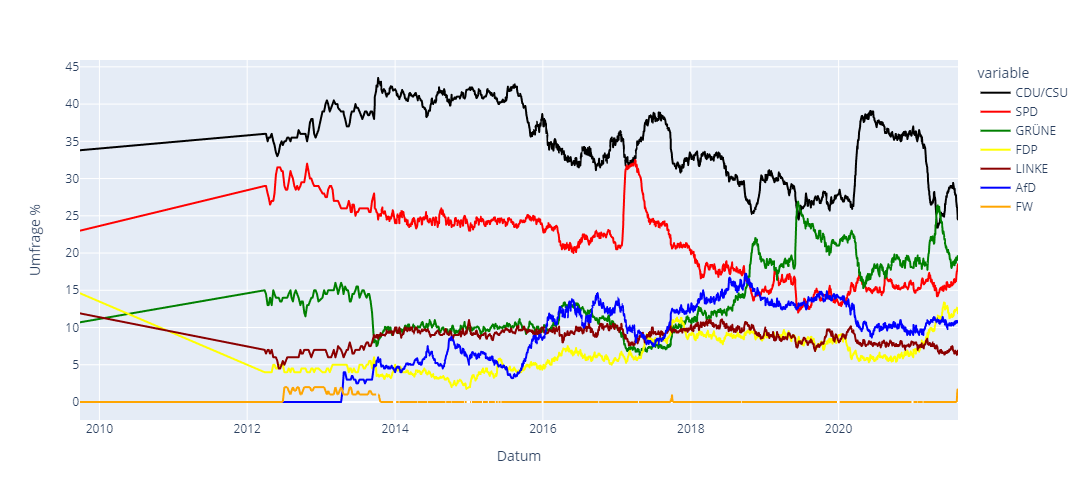

In [23]:
color_map = {
    "CDU/CSU": "black",
    "SPD": "red",
    "GRÜNE": "green",
    "FDP": "yellow",
    "LINKE": "darkred",
    "AfD": "blue",
    "FW": "orange",
}

plot_data = data.loc[:, ["CDU/CSU", "SPD", "GRÜNE", "FDP", "LINKE", "AfD", "FW"]]

fig = plot_data.rolling("8D").mean().plot(color_discrete_map=color_map)

fig.update_layout(yaxis_title="Umfrage %", height=500)

fig